Задача:
Нам надо предсказывать соавторов для определенного автора.
Из публикаций для каждого автора мы знаем его настоящих соавторов, эти данные можно использовать для обучения.

Варианты разбиения:

Информацию брал отсюда: https://arxiv.org/pdf/2007.13237.pdf

**Leave One Last**
<p>Для каждого автора берем его последнюю публикацию (его соавторов) и оставляем на тест, предпоследнюю публикацию оставляем на валидацию, остальные публикации - трейн.</p>
<p>Плюсы:</p>

* Используется максимум датасета для тренировки

<p>Минусы:</p>

* Возможен лик, так как одна и та же статься для одного автора может быть в трейне, а для другого в тесте.
* Тестовый датасет включает только одну запись для пользователя - мы не можем отследить динамику нашей рекомендательной системы по времени на тестовых данных.

**Temporal User Split**
<p>Схожа с Leave One Last, только для каждого автора берем какой-то фиксированный процент его последних публикаций и оставляем на тест/валидацию, остальные публикации - трейн.</p>

Плюсы и минусы схожи с Leave One Last методом. Здесь уже можем посмотреть динамику, однако опять же может быт лик.

**Temporal Global Split**
<p>Выбираем какой-нибудь год как барьер: все статьи до него - треин, после - тест.</p>

Плюсы:
* Нет даталика, не смотрим в будущее;
* Довольно просто разделять;

Минусы:
* Можем не ухватить какой-то новый тренд в науке, который появился недавно, так как его не будет в train. Или что в трейне было актуально, теперь в тесте уже не актуально.

**Random Split**
<p>Для каждого автора рандомо выбираем барьер, статьи до него - трейн, после него - тест.</p>

Минусы:
* В нашем случае будет даталик по аналогии с Leave One Last методом.

**User Split**
<p>Разделить выборку по авторам. То есть какие-то авторы только в трейне, а какие-то только в тесте.</p>

Плюсы:
* Мы охватываем весь временной отрезок в трейне.

Минусы:
* Сложно реализовать, нужно чтобы у авторов в трейне и в тесте не было общих статей вообще.
* Так как и трейн, и тест находятся в одних временных промежутках, у нас есть статьи в трейне, которые опубликованы позже, чем некоторые статьи в тесте, из-за этого у нас модель заглядывает в будущее и принимает решения, зная о последних трендах.

**Выводы**
<p>Из предложенных выше методов у нас нет лика только в Temporal Global Split, при этом его еще довольно просто реализовать. Мне кажется, что в качестве бейзлайна можнов выбрать его. Но если вдруг в выборке много важных статей опубликованы недавно, и нам важно захватить их в трейн, то можно попробовать еще User Split метод.</p>

In [2]:
import pandas as pd
from tqdm.notebook import tqdm as tqdm_notebook
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
FILE_ORIGIN = '../dblpv13.json'
FILE_PREPROCESSED = '../data.json'

In [4]:
CHUNKSIZE = 100000
MAX_OBSERVATIONS = 1000000 #Set to 55000000 if want all rows
df = pd.DataFrame()
with pd.read_json(FILE_PREPROCESSED, orient='records', lines=True, chunksize=CHUNKSIZE, nrows=MAX_OBSERVATIONS) as reader:
    for chunk_i, chunk in tqdm_notebook(enumerate(reader), total=MAX_OBSERVATIONS // CHUNKSIZE):
        df_new = pd.DataFrame(chunk)
        df_new['chunk_idx'] = chunk_i
        df = pd.concat([df, df_new], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
df

,_id,title,venue,year,keywords,n_citation,lang,authors,fos,page_start,...,volume,issue,issn,isbn,doi,pdf,url,abstract,references,chunk_idx
0,53e99784b7602d9701f3e3f5,3GIO.,{'type': 0},2011.0,[],0.0,en,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,53e99784b7602d9701f3e133,The relationship between canopy parameters and...,"{'_id': '53a7297d20f7420be8bd4ae7', 'name_d': ...",2011.0,"[canopy parameters, canopy spectrum, different...",0.0,en,"[{'_id': '53f45728dabfaec09f209538', 'name': '...","[Agronomy, Moisture, Hydrology, Environmental ...",1930,...,null,null,,,10.1109/IGARSS.2011.6049503,None,[http://dx.doi.org/10.1109/IGARSS.2011.6049503],Drought is the first place in all the natural ...,NaN,0
2,53e99784b7602d9701f3e151,A solution to the problem of touching and brok...,"{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"[handwriting recognition, prototypes, image se...",17.0,en,"[{'_id': '53f46797dabfaeb22f542630', 'name': '...","[Intelligent character recognition, Pattern re...",602,...,,,,,10.1109/ICDAR.1993.395663,None,[http://dx.doi.org/10.1109/ICDAR.1993.395663],,"[53e99cf5b7602d97025ace63, 557e8a7a6fee0fe990c...",0
3,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"{'_id': '53a72e2020f7420be8c80142', 'name_d': ...",2005.0,"[sequential circuits, statistical distribution...",28.0,en,"[{'_id': '53f43b03dabfaedce555bf2a', 'name': '...","[Delay calculation, Timing failure, Monte Carl...",2461,...,,,,0-7803-8834-8,10.1109/ISCAS.2005.1465124,//static.aminer.org/pdf/PDF/000/423/329/timing...,"[http://dx.doi.org/10.1109/ISCAS.2005.1465124,...",As process variations become a significant pro...,"[53e9a8a9b7602d97031f6bb9, 599c7b6b601a182cd27...",0
4,53e99784b7602d9701f3e161,360°,"{'_id': '5390a74a20f70186a0e8b40b', 'raw': 'AC...",2009.0,"[global high technology, daily short-distance ...",NaN,en,"[{'_id': '53f46946dabfaec09f24b4ed', 'name': '...",NaN,39,...,,,,,10.1145/1665137.1665166,NaN,NaN,360° represents the concerns that are addresse...,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,53e9a751b7602d9703087a04,Differentiable T-Norms and Related Membership ...,"{'_id': '53a72e3c20f7420be8c85f5c', 'name_d': ...",2000.0,"[related membership functions families, differ...",1.0,en,"[{'_id': '53f46007dabfaeb22f523986', 'name': '...","[Pure mathematics, Differentiable function, Ma...",294,...,,,,85-87837-03-6,,None,[],,NaN,9
999996,53e9a751b7602d9703087a10,A general modeling strategy for gene regulator...,"{'sid': 'JOURNAL OF COMPUTATIONAL BIOLOGY', 'i...",2006.0,"[gene regulatory networks (GRNs), genetic togg...",134.0,en,"[{'_id': '5440bd20dabfae805a6eed3d', 'name': '...","[Gene, Expression (mathematics), Computer scie...",1630.0,...,13.0,9,1066-5277,,10.1089/cmb.2006.13.1630,None,"[http://dx.doi.org/10.1089/cmb.2006.13.1630, h...",A stochastic genetic toggle switch model that ...,"[53e9b0b2b7602d9703b23276, 53e99b3cb7602d97023...",9
999997,53e9a751b7602d9703087a11,Evolutionärer Test des Zeitverhaltens von Real...,"{'_id': '53a731f220f7420be8d6d309', 'name_d': ...",2004.0,[],22.0,en,"[{'_id': '5429f8cddabfae5346af4a45', 'name': '...","[Evolutionary testing, Computer science, Real-...",101,...,46,2,,,10.1524/itit.46.2.101.29085,None,[http://dx.doi.org/10.1524/itit.46.2.101.29085...,NaN,NaN,9
999998,53e9a751b7602d9703087a15,Word Separation of Unconstrained Handwritten T...,"{'_id': '53a72a4920f7420be8bfa51b', 'type': 0,...",2005.0,"[carbon copy, heuristics-based approach, handw...",3.0,en,"[{'_id': '53f43083dabfaec22ba3ff6c', 'name': '...","[Market segmentation, Stroke width, Scale-spac...",715,...,,,1520-5363,0-7695-2420-6,10.1109/ICDAR.2005.255,//static.aminer.org/pdf/PDF/000/295/340/word_s...,"[http://dx.doi.org/10.1109/ICDAR.2005.255, htt...",An approach for segmenting handwritten text in...,"[53e99c59b7602d970250866e, 53e9bda5b7602d9704a...",9


In [6]:
year = 2010
f'test : {len(df[df.year > year]) / len(df)}, train: {len(df[df.year <= year]) / len(df)}' 

'test : 0.249867, train: 0.750126'

In [7]:
test = df[df.year > year]
train = df[df.year <= year]

In [8]:
def get_authors(x):
    authors = []
    if isinstance(x, list):
        for author in x:
            if 'name' in author:
                authors.append(author['name'])
    return authors

In [9]:
train['authors_list'] = train.authors.apply(get_authors)

/var/folders/r_/bq4swdms3vj5wr80yf1vm4nh0000gn/T/ipykernel_8287/626911778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['authors_list'] = train.authors.apply(get_authors)


In [10]:
def get_coocurance(df, max_rows):
    coocurance_train = (pd.get_dummies(pd.DataFrame(list(df['authors_list'])[:max_rows]), prefix='', prefix_sep='')
           .groupby(level=0, axis=1)
           .sum())

    v = coocurance_train.T.dot(coocurance_train)
    v.values[(np.r_[:len(v)], ) * 2] = 0
    return v

In [11]:
%%time
coocurance_train = get_coocurance(train, 1000)

CPU times: user 2.14 s, sys: 21.3 ms, total: 2.16 s
Wall time: 2.16 s


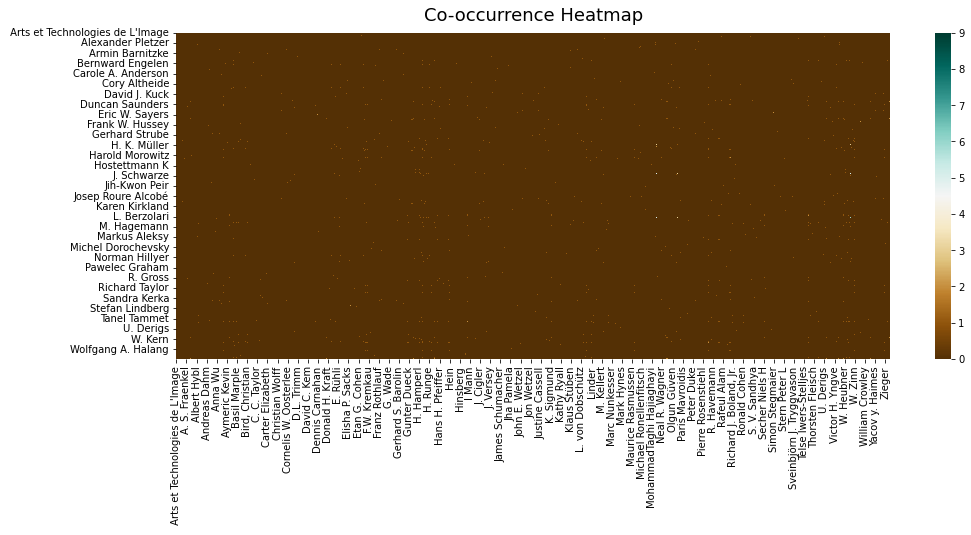

In [12]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(coocurance_train, annot=False, cmap='BrBG')
heatmap.set_title('Co-occurrence Heatmap', fontdict={'fontsize':18}, pad=12);